In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
from glob import glob
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_csv = "/content/drive/MyDrive/AI4EO_FinalProject_SimayDelibas/train_Final.csv"
val_csv   = "/content/drive/MyDrive/AI4EO_FinalProject_SimayDelibas/val_Final.csv"
test_csv  = "/content/drive/MyDrive/AI4EO_FinalProject_SimayDelibas/test_Final.csv"

train_img_dir = "/content/drive/MyDrive/AI4EO_FinalProject_SimayDelibas/FireRisk_TrainValSet_Final/train"
val_img_dir   = "/content/drive/MyDrive/AI4EO_FinalProject_SimayDelibas/FireRisk_TrainValSet_Final/val"
test_img_dir  = "/content/drive/MyDrive/AI4EO_FinalProject_SimayDelibas/FireRisk_TestSet_Final"

tabular_cols = [
    'NDVI', 'NBR', 'Burned', 'frp', 'confidence', 'temp_c', 'wind_mps', 'precip_m',
    'burn_count', 'fire_potential', 'wind_conf', 'risk_factor', 'risk_persistence'
]

Mounted at /content/drive


In [28]:
class HybridDataset(Dataset):
    def __init__(self, csv_path, image_dir, tabular_cols, label_col='class', transform=None):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.tabular_cols = tabular_cols
        self.label_col = label_col

        self.transform = transform or T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.class2idx = {
            'Very_Low': 0, 'Low': 1, 'Moderate': 2, 'High': 3,
            'Very_High': 4, 'Non-burnable': 5, 'Water': 6
        }

        self.df['label'] = self.df[label_col].map(self.class2idx)

        self.image_paths = {
            os.path.basename(p): p
            for p in glob(os.path.join(self.image_dir, '**', '*.png'), recursive=True)
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            filename = row["filename"]
            img_path = self.image_paths.get(filename)

            if img_path is None or not os.path.exists(img_path):
                print(f"[SKIPPED] Image path not found or does not exist: {filename}")
                image = torch.zeros(3, 224, 224)
            else:
                try:
                    if idx % 500 == 0:
                        print(f"[INFO] Getting item {idx}: {filename}")
                    image = Image.open(img_path).convert("RGB")
                    image = self.transform(image)
                except Exception as e:
                    print(f"[SKIPPED] Failed to process image: {filename} | Error: {e}")
                    image = torch.zeros(3, 224, 224)

            tabular_values = row[self.tabular_cols].astype(float).values
            tabular = torch.tensor(tabular_values, dtype=torch.float32)
            label = torch.tensor(row["label"], dtype=torch.long)

            return {
                "image": image,
                "tabular": tabular,
                "label": label
            }

        except Exception as e:
            print(f"[SKIPPED] General error at idx={idx} | Error: {e}")
            return {
                "image": torch.zeros(3, 224, 224),
                "tabular": torch.zeros(len(self.tabular_cols)),
                "label": torch.tensor(0)
            }

train_dataset = HybridDataset(train_csv, train_img_dir, tabular_cols)
val_dataset = HybridDataset(val_csv, val_img_dir, tabular_cols)
test_dataset = HybridDataset(test_csv, test_img_dir, tabular_cols)

print("Train sample:", train_dataset[0])
print("Validation sample:", val_dataset[0])
print("Test sample:", test_dataset[0])


[INFO] Getting item 0: 34630751_6_-99.4428346545151_43.2516783980339.png
Train sample: {'image': tensor([[[-0.8335, -0.6965, -0.6794,  ..., -0.9192, -0.9192, -0.8507],
         [-0.8849, -0.7650, -0.7308,  ..., -0.8335, -0.8335, -0.8335],
         [-0.9534, -0.8678, -0.7650,  ..., -0.8335, -0.8678, -0.8849],
         ...,
         [-1.1589, -1.1760, -1.1760,  ..., -1.1075, -1.1418, -1.1418],
         [-1.1932, -1.1418, -1.1932,  ..., -1.0904, -1.1247, -1.1589],
         [-1.1760, -1.1760, -1.1418,  ..., -1.0562, -1.1247, -1.1247]],

        [[-0.0574,  0.1001,  0.1001,  ..., -0.1975, -0.2150, -0.1625],
         [-0.1450, -0.0224,  0.0826,  ..., -0.1099, -0.0574, -0.0749],
         [-0.2325, -0.1800, -0.0749,  ..., -0.0399, -0.0399, -0.0574],
         ...,
         [-0.7052, -0.7402, -0.7227,  ..., -0.6001, -0.6702, -0.7402],
         [-0.7227, -0.6877, -0.7227,  ..., -0.6176, -0.6877, -0.7402],
         [-0.7227, -0.7227, -0.7227,  ..., -0.6001, -0.6877, -0.7227]],

        [[ 0.0082, 

In [4]:
class HybridNet(nn.Module):
    def __init__(self, tabular_input_dim, num_classes):
        super(HybridNet, self).__init__()

        # Pretrained CNN (ResNet18)
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()
        self.cnn_out_dim = self.cnn.fc.in_features if hasattr(self.cnn.fc, 'in_features') else 512

        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, tabular):
        image_feat = self.cnn(image)
        tabular_feat = self.tabular_net(tabular)
        fused = torch.cat((image_feat, tabular_feat), dim=1)
        out = self.classifier(fused)
        return out


In [40]:
batch_size = 32
num_workers = 2
num_classes = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

sample_batch = next(iter(train_loader))
print("Batch image shape:", sample_batch['image'].shape)
print("Batch tabular shape:", sample_batch['tabular'].shape)
print("Batch label shape:", sample_batch['label'].shape)

assert sample_batch['image'].shape == (batch_size, 3, 224, 224)
assert sample_batch['tabular'].shape[0] == batch_size
assert sample_batch['label'].shape[0] == batch_size

model = HybridNet(tabular_input_dim=len(tabular_cols), num_classes=num_classes).to(device)
train_labels_array = train_dataset.df["label"].values
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_array),
    y=train_labels_array
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.Adam(model.parameters(), lr=1e-3)


Batch image shape: torch.Size([32, 3, 224, 224])
Batch tabular shape: torch.Size([32, 13])
Batch label shape: torch.Size([32])


In [41]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch, checkpoint_path):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch_idx, batch in enumerate(dataloader):
        images = batch["image"].to(device)
        tabular = batch["tabular"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(images, tabular)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % 200 == 0:
            print(f"[{batch_idx}] Loss: {loss.item():.4f}")

        if batch_idx % 100 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, checkpoint_path)
            print(f"[✓] Intermediate checkpoint saved at batch {batch_idx}")

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / float(total)
    epoch_acc = correct / float(total)
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            tabular = batch["tabular"].to(device)
            labels = batch["label"].to(device)

            outputs = model(images, tabular)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / float(total)
    epoch_acc = correct / float(total)
    return epoch_loss, epoch_acc


In [42]:
num_epochs = 7
checkpoint_path = "/content/drive/MyDrive/AI4EO_FinalProject_SimayDelibas/checkpoint_final.pth"

start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"[INFO] Resuming training from epoch {start_epoch + 1}...")
else:
    print("[INFO] No checkpoint found. Starting fresh training...")

for epoch in range(start_epoch, num_epochs):
    print(f"\n[INFO] Starting epoch {epoch+1}/{num_epochs}...")

    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device, epoch, checkpoint_path
    )

    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f"    Epoch [{epoch+1}/{num_epochs}]")
    print(f"    Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"    Validation Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

[INFO] No checkpoint found. Starting fresh training...

[INFO] Starting epoch 1/7...
[0] Loss: 1.9205
[✓] Intermediate checkpoint saved at batch 0
[INFO] Getting item 5500: 35173931_6_-89.3477705941239_43.043304491966.png
[INFO] Getting item 49500: 31221301_1_-91.7797288950928_43.7665192953323.png
[INFO] Getting item 13000: 31000201_6_-100.296400381558_43.797982643678.png
[INFO] Getting item 0: 34630751_6_-99.4428346545151_43.2516783980339.png
[INFO] Getting item 47000: 35106941_1_-106.987386565242_42.7596958982704.png
[✓] Intermediate checkpoint saved at batch 100
[INFO] Getting item 6500: 34743171_6_-84.8879835068933_42.8074819681909.png
[INFO] Getting item 28500: 28679751_3_-98.1150523417507_44.2141430487962.png
[INFO] Getting item 53500: 27443571_1_-74.4002828944626_42.6396989189965.png
[INFO] Getting item 2500: 35283271_6_-84.7434555451214_42.7098869008513.png
[INFO] Getting item 15000: 27424651_6_-88.6437649885824_44.2238150185334.png
[200] Loss: 1.2693
[✓] Intermediate checkpoin

In [43]:
model.eval()
torch.save(model.state_dict(), "/content/drive/MyDrive/AI4EO_FinalProject_SimayDelibas/best_model_final.pth")
print("[INFO] Model saved successfully ")


[INFO] Model saved successfully 


In [44]:
model.load_state_dict(torch.load("/content/drive/MyDrive/AI4EO_FinalProject_SimayDelibas/best_model_final.pth"))
model.eval()

HybridNet(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [45]:
all_preds = []
all_labels = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        try:
            images = batch["image"].to(device)
            tabular = batch["tabular"].to(device)
            labels = batch["label"].to(device)

            outputs = model(images, tabular)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        except Exception as e:
            print(f"[SKIPPED] Error in batch {i}: {e}")
            continue

[INFO] Getting item 0: 31248581_6_-104.931364107981_43.5265776012407.png
[INFO] Getting item 500: 29962461_6_-100.06035838654_43.9677746812099.png
[INFO] Getting item 1000: 29780851_6_-91.2124655402909_43.9725732458994.png
[INFO] Getting item 1500: 30152981_6_-76.5226102911936_42.5469271021274.png
[INFO] Getting item 2000: 34286671_5_-115.159843469921_41.9317867103059.png
[INFO] Getting item 2500: 35092861_3_-102.540364351365_43.0610609608108.png
[INFO] Getting item 3000: 33706971_7_-98.6768176239831_43.4146827755912.png
[INFO] Getting item 3500: 27554561_2_-121.651418150204_41.8657319594828.png
[INFO] Getting item 4000: 27989831_2_-119.599732824391_42.1956398466362.png
[INFO] Getting item 4500: 35336511_4_-112.696103479989_42.1105232319761.png
[INFO] Getting item 5000: 33031901_1_-95.1307416275158_43.5454681109797.png
[INFO] Getting item 5500: 29846081_1_-75.0619764370498_42.3658011382319.png
[SKIPPED] Failed to process image: 27057911_1_-121.068397893318_42.0630694055531.png | Error:

Accuracy: 0.5076
F1 Score: 0.5050

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.58      0.59      1695
           1       0.38      0.27      0.32      1070
           2       0.35      0.14      0.20       861
           3       0.35      0.33      0.34       629
           4       0.24      0.78      0.37       326
           5       0.82      0.73      0.77      1795
           6       0.30      0.90      0.45       172

    accuracy                           0.51      6548
   macro avg       0.43      0.53      0.43      6548
weighted avg       0.54      0.51      0.50      6548



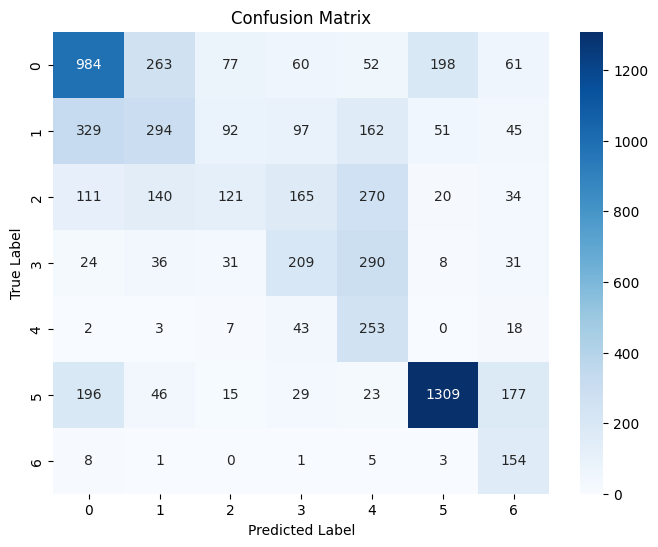

In [46]:
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()